Optimal number of features : 15


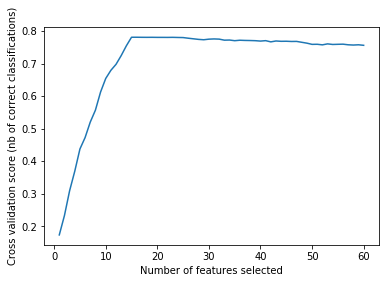

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import feature_selection as fs
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

from skcriteria import Data, MAX, MIN
from skcriteria.madm import topsis, electre
from skcriteria.weights import critic

import pandas as pd

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=10000, n_features=60, n_informative=15,
                           n_redundant=4, n_repeated=5, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [2]:
kbest_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k="all")
kbest_mutual_info.fit(X, y)
kbest_anova = fs.SelectKBest(fs.f_classif, k="all")
kbest_anova.fit(X, y)
kbest_chi2 = fs.SelectKBest(fs.chi2, k="all")
kbest_chi2.fit(X ** 2, y)

SelectKBest(k='all', score_func=<function chi2 at 0x7fe45b9fe848>)

In [3]:
result = pd.DataFrame(
    data={
    "mutual_info_classif": kbest_mutual_info.scores_,
    "anova": kbest_anova.scores_,
    "chi2": kbest_chi2.scores_      
})
skc_data = Data(
    result.as_matrix(), [MAX, MAX, MAX], 
    cnames=result.columns.values)
w_skc_data = critic.CriticWeights().decide(skc_data)
w_skc_data

ALT./CRIT.,anova (max) W.0.279325871879,chi2 (max) W.0.443255151826,mutual_info_classif (max) W.0.277418976294
A0,1.95585,19.5005,0.00987544
A1,1.34351,18.3361,0.00700994
A2,0.766278,6.85968,0.0126303
A3,0.853234,5.49822,0
A4,241.387,2673.93,0.0953951
A5,196.883,1678.53,0.0705611
A6,226.924,1353.85,0.0870041
A7,0.333432,21.0986,0.000378802
A8,320.624,2160.58,0.113203
A9,1.19575,3.05948,0.0100216


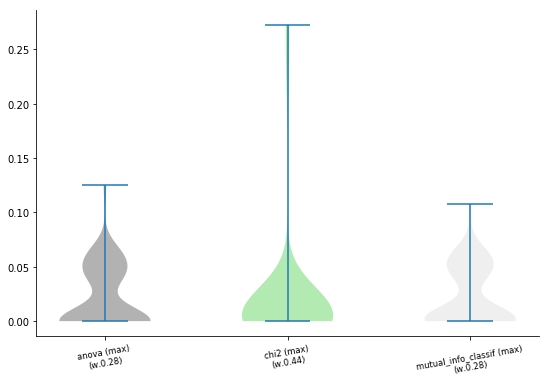

In [4]:
ax = w_skc_data.plot.violin(mnorm="vector", cmap="nipy_spectral", weighted=True)
plt.show()

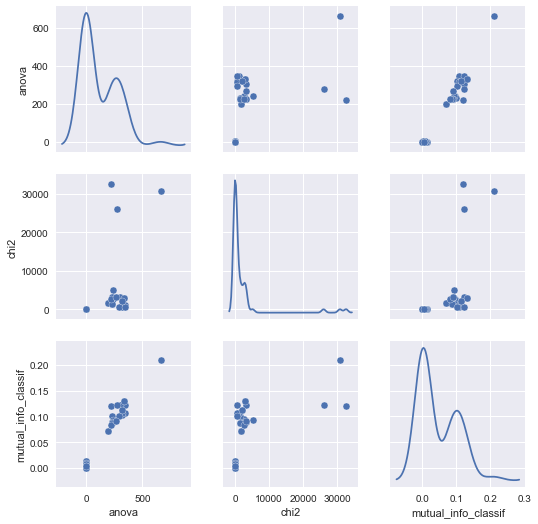

In [5]:
import seaborn as sns
sns.set()

sns.pairplot(result, diag_kind="kde")
plt.show()

In [6]:
tdec = topsis.TOPSIS().decide(w_skc_data)

In [7]:
closeness = np.sort(tdec.e_.closeness)[::-1]
closeness_cs = np.cumsum(closeness)
X_order_col = np.asarray(skc_data.anames)[np.argsort(tdec.rank_)]

ticks_range = np.arange(len(skc_data.anames))

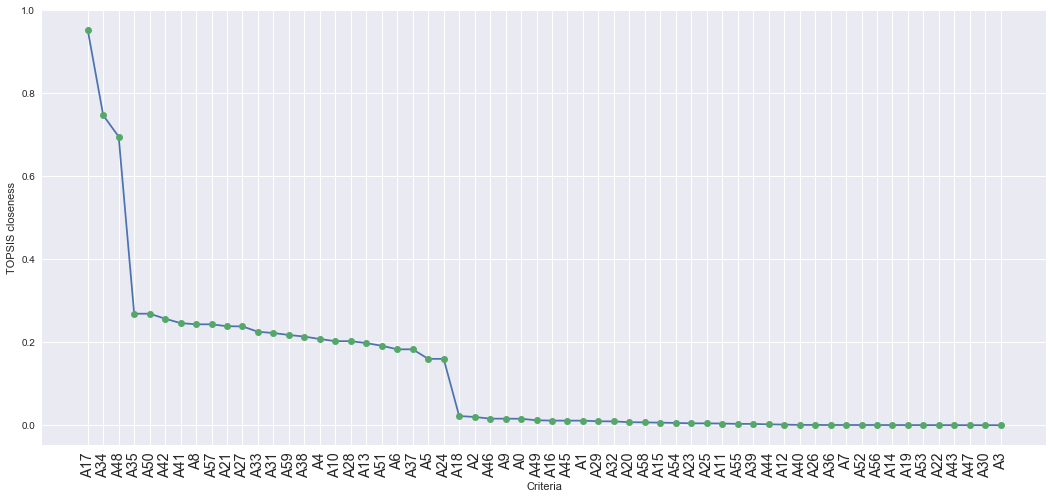

In [8]:
ax = plt.subplots(figsize=(18, 8))[-1]
ax.plot(closeness, "-")
ax.plot(closeness, "o")
ax.set_ylabel('TOPSIS closeness')
ax.set_xlabel("Criteria")

ax.set_xticks(ticks_range)
ax.set_xticklabels(X_order_col, rotation=90, size="large")
plt.show()

In [9]:
len(tdec.rank_)

60

In [12]:
c0 = set(np.arange(60)[np.argsort(rfecv.ranking_)][:24])
c1 = set(np.arange(60)[np.argsort(tdec.rank_)][:24])
c1.difference(c0), len(c0)

(set(), 24)